# __Trying Ocean regimes indicator__

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib as mpl

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

### Dataset

One year of SST data in mediterranean:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [2]:
file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1607013925530.nc'

Open dataset

In [3]:
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, time: 8760)
Coordinates:
  * time                                           (time) datetime64[ns] 2019-01-01T00:30:00 ... 2019-12-31T23:30:00
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
Data variables:
    sea_surface_warm_layer_temperature_difference  (time, lat, lon) float32 ...
    sea_surface_cool_skin_temperature_difference   (time, lat, lon) float32 ...
    analysed_sst                                   (time, lat, lon) float32 ...
    mask                                           (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      Global Diurnal Skin SST Analysis, L4 OSTIA, 0...
    summary:                    A merged, multi-sensor L4 skin SST product
    references:                 While J., Martin M.; 2013;  Development of a ...
    institution:                UKMO
    history:                    See source and creation_date attributees
    comment:                    WARNING Some applications are unable to prope...
    license:                    These data are available free of charge under...
    id:                         UKMO-L4LRskin_GLOB-OSTIAdiu
    naming_authority:           org.ghrsst
    product_version:            1.2
    uuid:                       dd7afcc1-acf0-4a0f-9407-19d49b470b7b
    gds_version_id:             2.4
    netcdf_version_id:          4.1
    date_created:               20201203T081437Z
    start_time:                 20201202T000000Z
    time_coverage_start:        20201202T000000Z
    stop_time:                  20201202T235959Z
    time_coverage_end:          20201202T235959Z
    file_quality_level:         3
    source:                     NAVO-L2P-AVHRR19_G, OSPO-L2P-GOES15, SEVIRI_S...
    platform:                   NOAA-19, GOES15, MSG2, MTSAT2
    sensor:                     AVHRR, Imager, SEVIRI, Imager
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    metadata_link:              Not yet available
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    westernmost_longitude:      -180.0
    easternmost_longitude:      180.0
    southernmost_latitude:      -90.0
    northernmost_latitude:      90.0
    spatial_resolution:         0.25 degree
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    acknowledgment:             Please acknowledge the use of these data with...
    creator_name:               Met Office as part of CMEMS
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    creator_url:                http://marine.copernicus.eu/
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...
    geospatial_lat_min:         30.125
    geospatial_lat_max:         46.125
    geospatial_lon_min:         -4.875
    geospatial_lon_max:         42.875

Quick plot

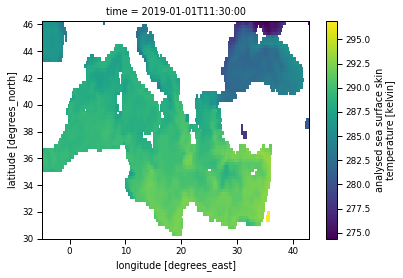

In [4]:
ds['analysed_sst'].isel(time=11).plot();

In [ ]:
bins = np.arange(int(ds['analysed_sst'].min().values), int(ds['analysed_sst'].max().values))
ds['analysed_sst'].plot.hist(bins=bins);

Plot mask (water = 1)

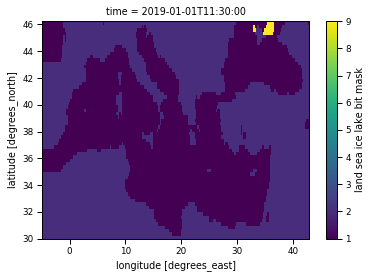

In [5]:
ds['mask'].isel(time=11).plot();

### Preprocessing

1) weekly mean for each pixel

In [6]:
ds = ds.groupby("time.week").mean()
ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values
/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, week: 52)
Coordinates:
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
  * week                                           (week) int64 1 2 3 ... 51 52
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, lat, lon) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (week, lat, lon) float32 nan ... 0.0
    analysed_sst                                   (week, lat, lon) float32 nan ... 275.3912
    mask                                           (week, lat, lon) float32 2.0 ... 1.0

In [ ]:
ds['analysed_sst'].plot.hist(bins=bins);

Text(0, 0.5, 'Counts')

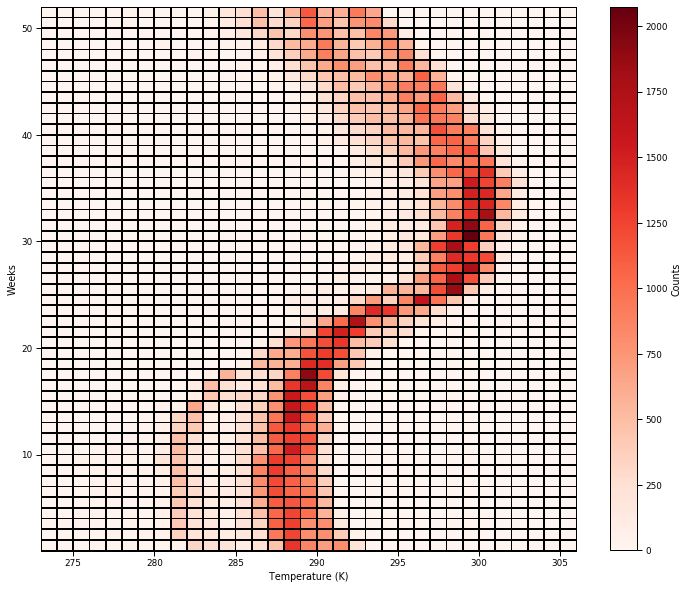

In [7]:
bins = np.arange(int(ds['analysed_sst'].min().values), int(ds['analysed_sst'].max().values))
histo_2d = [] 
for iweek in range(52):
    hist_values, bin_edges = np.histogram(ds['analysed_sst'].isel(week=iweek).values, bins=bins)
    histo_2d.append(hist_values)
    
fig, ax = plt.subplots(figsize=(12,10))
plt.pcolormesh(bins, ds.week.values, histo_2d, cmap='Reds', edgecolors='black')
cbar = plt.colorbar()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Weeks')
cbar.ax.set_ylabel('Counts')

2) Reduce lat lon dimensions to one dimension

In [26]:
sampling_dims = list(ds.dims)
sampling_dims.remove('week')
sampling_dims

['lat', 'lon']

In [14]:
X = ds.stack({'sampling': sampling_dims})
X.rename_dims({'week': 'feature'})
X

<xarray.Dataset>
Dimensions:                                        (sampling: 12480, week: 52)
Coordinates:
  * week                                           (week) int64 1 2 3 ... 51 52
  * sampling                                       (sampling) MultiIndex
  - lat                                            (sampling) float64 30.12 ... 46.12
  - lon                                            (sampling) float64 -4.875 ... 42.88
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, sampling) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (week, sampling) float32 nan ... 0.0
    analysed_sst                                   (week, sampling) float32 nan ... 275.3912
    mask                                           (week, sampling) float32 2.0 ... 1.0

In [ ]:
X['analysed_sst'].plot.hist(bins=bins);

3) Delate all NaN time series using mask

In [15]:
stacked_mask = X['mask']
stacked_mask

<xarray.DataArray 'mask' (week: 52, sampling: 12480)>
array([[2., 2., 2., ..., 2., 2., 1.],
       [2., 2., 2., ..., 2., 2., 1.],
       [2., 2., 2., ..., 2., 2., 1.],
       ...,
       [2., 2., 2., ..., 2., 2., 1.],
       [2., 2., 2., ..., 2., 2., 1.],
       [2., 2., 2., ..., 2., 2., 1.]], dtype=float32)
Coordinates:
  * week      (week) int64 1 2 3 4 5 6 7 8 9 10 ... 44 45 46 47 48 49 50 51 52
  * sampling  (sampling) MultiIndex
  - lat       (sampling) float64 30.12 30.12 30.12 30.12 ... 46.12 46.12 46.12
  - lon       (sampling) float64 -4.875 -4.625 -4.375 ... 42.38 42.62 42.88

In [43]:
X = X['analysed_sst'].where(stacked_mask == 1, drop=True).to_dataset()
X

<xarray.Dataset>
Dimensions:       (sampling: 5723, week: 52)
Coordinates:
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    analysed_sst  (week, sampling) float32 291.3304 291.29144 ... 275.3912

In [ ]:
X['analysed_sst'].plot.hist(bins=bins);

recover the dataset (unravel)

In [75]:
sampling_dims.append('week')
coords = list()
size = list()
for dim in sampling_dims:
    coords.append(ds[dim])
    size.append(len(ds[dim]))

In [76]:
X_unstacked = xr.DataArray(np.empty((size)), coords=coords)
sampling_dims.remove('week')
X_unstacked = X_unstacked.stack({'sampling': sampling_dims})
X_unstacked = X_unstacked.where(stacked_mask == 1, drop=True)
X_unstacked.values = X['analysed_sst']
X_unstacked = X_unstacked.unstack('sampling').to_dataset(name = 'analysed_sst')
X_unstacked = X_unstacked.sortby(['lat','lon'])

X_unstacked 

<xarray.Dataset>
Dimensions:       (lat: 64, lon: 191, week: 52)
Coordinates:
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * lat           (lat) float64 30.38 30.62 30.88 31.12 ... 45.62 45.88 46.12
  * lon           (lon) float64 -4.875 -4.625 -4.375 ... 42.38 42.62 42.88
Data variables:
    analysed_sst  (week, lat, lon) float32 nan nan nan nan ... nan nan 275.3912

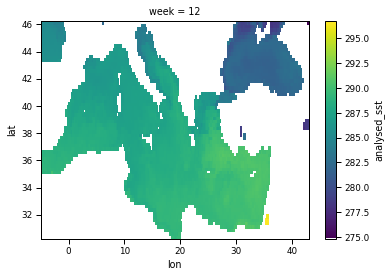

In [78]:
X_unstacked['analysed_sst'].isel(week=11).plot();

There is any NaN in the dataset?

In [81]:
np.any(np.isnan(X['analysed_sst'].values))

True

4) Interpolation

In [97]:
X = X['analysed_sst'].interpolate_na(dim = 'week', method="linear", fill_value="extrapolate").to_dataset(name = 'analysed_sst')
X

<xarray.Dataset>
Dimensions:       (sampling: 5723, week: 52)
Coordinates:
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    analysed_sst  (week, sampling) float32 291.3304 291.29144 ... 275.3912

In [98]:
np.any(np.isnan(X['analysed_sst'].values))

False

5) Scaler

In [168]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X['analysed_sst'])
X_scale = X.assign(variables={"analysed_sst_scaled":(('week', 'sampling'), X_scale)})
X_scale

<xarray.Dataset>
Dimensions:              (sampling: 5723, week: 52)
Coordinates:
  * sampling             (sampling) MultiIndex
  - lat                  (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                  (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
  * week                 (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
Data variables:
    analysed_sst         (week, sampling) float32 291.3304 ... 275.3912
    analysed_sst_scaled  (week, sampling) float32 -0.7799568 ... -1.1266707

5) PCA

In [131]:
# dim should be n_samples, n_features
X = X.transpose()
X

<xarray.Dataset>
Dimensions:       (sampling: 5723, week: 52)
Coordinates:
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    analysed_sst  (week, sampling) float32 291.3304 291.29144 ... 275.3912

In [132]:
from sklearn.decomposition import PCA
pca = PCA()
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [133]:
X_reduced = pca.fit_transform(X['analysed_sst'])
np.shape(X_reduced)

(52, 52)

In [169]:
X_reduced = pca.fit_transform(X_scale['analysed_sst_scaled'])
np.shape(X_reduced)

(52, 52)

### Apply Model

In [170]:
from sklearn import mixture
model = mixture.GaussianMixture(n_components=4, covariance_type='full')
model

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [171]:
model.fit(X_reduced)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [172]:
X_labels = model.predict(X_scale['analysed_sst_scaled'].transpose())
X_labels

array([1, 1, 1, ..., 1, 1, 1])

In [173]:
X_labels.min()

1

In [174]:
Xr_labels = model.predict(X_reduced)
Xr_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3])

Trying without pca

In [146]:
X

<xarray.Dataset>
Dimensions:       (sampling: 5723, week: 52)
Coordinates:
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    analysed_sst  (week, sampling) float32 291.3304 291.29144 ... 275.3912

In [176]:
model2 = mixture.GaussianMixture(n_components=4, covariance_type='full')
model2.fit(X_scale['analysed_sst_scaled'])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [181]:
labels2 = model.predict(X_scale['analysed_sst_scaled'].transpose())
np.shape(labels2)

(5723,)

In [179]:
labels2.max()

3

In [180]:
labels2.min()

1

In [182]:
X_labels = X_scale.assign(variables={"PCM_labels":(('sampling'), labels2)})
X_labels

<xarray.Dataset>
Dimensions:              (sampling: 5723, week: 52)
Coordinates:
  * sampling             (sampling) MultiIndex
  - lat                  (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                  (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
  * week                 (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
Data variables:
    analysed_sst         (week, sampling) float32 291.3304 ... 275.3912
    analysed_sst_scaled  (week, sampling) float32 -0.7799568 ... -1.1266707
    PCM_labels           (sampling) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1

### Plot

unstack dataset

In [185]:
X_un = X_labels.unstack('sampling')
X_un = X_un.sortby(['lat','lon'])
X_un

<xarray.Dataset>
Dimensions:              (lat: 64, lon: 191, week: 52)
Coordinates:
  * week                 (week) int64 1 2 3 4 5 6 7 8 ... 46 47 48 49 50 51 52
  * lat                  (lat) float64 30.38 30.62 30.88 ... 45.62 45.88 46.12
  * lon                  (lon) float64 -4.875 -4.625 -4.375 ... 42.62 42.88
Data variables:
    analysed_sst         (week, lat, lon) float32 nan nan nan ... nan 275.3912
    analysed_sst_scaled  (week, lat, lon) float32 nan nan nan ... nan -1.1266707
    PCM_labels           (lat, lon) float64 nan nan nan nan ... nan nan nan 1.0

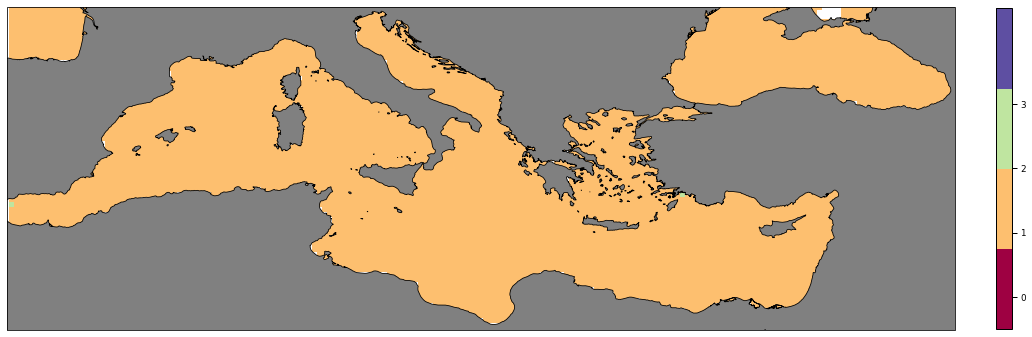

In [188]:
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='10m',facecolor='grey')
fig=plt.figure(figsize=(18,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(land_feature, edgecolor='black')
ax.set_extent([-5, 42, 30, 46], crs=ccrs.PlateCarree())
plt.pcolormesh(X_un['lon'], X_un['lat'], X_un['PCM_labels'], vmin=0, vmax=3, cmap=plt.cm.get_cmap('Spectral', 4))
plt.colorbar(ticks=range(4),fraction=0.016, pad=0.04)
plt.clim([-0.5,4.5])
plt.show()

trying kmeans

In [190]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [191]:
km.fit(X_scale['analysed_sst_scaled'])
labels = km.labels_

In [192]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 2, 2, 2, 2, 2, 2, 2], dtype=int32)